In [1]:
import implicit
import pandas as pd
import sqlite3

# Open database connection

In [10]:
conn = sqlite3.connect('fsdata.db')
print("Database opened successfully")

Database opened successfully


# 1. Perform data munging

Notice there are socialgraph user which are not in users table, and not having bi-direction relationship.

This records has to be cleaned up.

## Clean socialgraph table from invalid user id, to contain only bi-direction network

In [11]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select id from users)"
sql += " or second_user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't exists in users table deleted successfully")

Record on socialgraph which doesn't exists in users table deleted successfully


In [12]:
sql = "DELETE FROM socialgraph WHERE first_user_id not in (select second_user_id from socialgraph)"
sql += " or second_user_id not in (select first_user_id from socialgraph)"
conn.execute(sql)
conn.commit()
print("Record on socialgraph which doesn't have bi-direction reference first & second user_id deleted successfully")

Record on socialgraph which doesn't have bi-direction reference first & second user_id deleted successfully


## Clean ratings and checkins tables from invalid user_id and invalid venue_id

In [13]:
sql = "DELETE FROM ratings WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in users table deleted successfully")

Record on ratings which doesn't exists in users table deleted successfully


In [14]:
sql = "DELETE FROM ratings WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on ratings which doesn't exists in venues table deleted successfully")

Record on ratings which doesn't exists in venues table deleted successfully


In [15]:
sql = "DELETE FROM checkins WHERE user_id not in (select id from users)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in users table deleted successfully")

Record on checkins which doesn't exists in users table deleted successfully


In [16]:
sql = "DELETE FROM checkins WHERE venue_id not in (select id from venues)"
conn.execute(sql)
conn.commit()
print("Record on checkins which doesn't exists in venues table deleted successfully")

Record on checkins which doesn't exists in venues table deleted successfully


# 2. Load Data

## Load Users

In [17]:
users = pd.read_sql_query("select * from users", conn)
users.head(5)

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144


In [18]:
users.shape

(2153469, 3)

## Load Venues

In [19]:
venues = pd.read_sql_query("select * from venues", conn)
venues.head(5)

,id,latitude,longitude
0,1,44.882011,-93.212364
1,2,44.883169,-93.213687
2,3,44.883455,-93.214316
3,4,44.881387,-93.213801
4,5,44.882129,-93.214012


In [20]:
venues.shape

(1143090, 3)

## Load Ratings

In [21]:
ratings = pd.read_sql_query("select * from ratings", conn)
ratings.head(5)

,user_id,venue_id,rating
0,1,1,5
1,1,51,4
2,1,51,2
3,1,51,5
4,1,52,5


In [22]:
ratings.shape

(2809580, 3)

## Load Checkins

In [23]:
checkins = pd.read_sql_query("select * from checkins", conn)
checkins.head(5)

,id,user_id,venue_id,latitude,longitude,created_at
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50


In [24]:
checkins.shape

(1021966, 6)

## Load SocialGraph

In [26]:
socialgraph = pd.read_sql_query("select * from socialgraph", conn)
socialgraph.head(5)

,first_user_id,second_user_id
0,1,10
1,10,1
2,1,11
3,11,1
4,1,12


In [27]:
socialgraph.shape

(27098469, 2)

## Load user's social

In [ ]:
sql = "select u.*, s.second_user_id from users u left join socialgraph s on s.first_user_id = u.id"
users_social = pd.read_sql_query(sql, conn)
users_social

# 3. Looking for Insights

## For each venues, how many users checkins?

In [28]:
sql = "select venue_id, count(*) from checkins group by venue_id order by count(*) desc"
venue_checkins = pd.read_sql_query(sql, conn)
venue_checkins

,venue_id,count(*)
0,5222,25366
1,7620,23622
2,2297,23415
3,11195,19463
4,11138,18088
...,...,...
83994,87,1
83995,79,1
83996,76,1
83997,4,1


## For each venues, how many times user <span style="color:red">repeat checkins</span>?

In [30]:
sql = "select venue_id, user_id, count(*) as x_times_checkin from checkins group by venue_id, user_id having count(*) > 1 order by count(*) desc"
venue_checkins_user_repeat = pd.read_sql_query(sql, conn)
venue_checkins_user_repeat

,venue_id,user_id,x_times_checkin
0,7491,1348362,53
1,11138,660409,41
2,4432,439413,40
3,64,517520,39
4,4432,304865,39
...,...,...,...
85406,1139662,1391424,2
85407,1140238,356927,2
85408,1140905,2045336,2
85409,1142479,2056786,2


## <span style="color:red">Which are the top 10 users has more checkins?</span>

In [31]:
sql = "select user_id, count(*) as x_times_checkin from checkins group by user_id order by count(*) desc limit 10"
users_top_10_checkins = pd.read_sql_query(sql, conn)
users_top_10_checkins

,user_id,x_times_checkin
0,1348362,57
1,1900906,52
2,1326476,48
3,1365850,47
4,386648,47
5,467043,46
6,651415,45
7,439413,45
8,304865,45
9,8622,45


## Is there any venue rated multiple times by a user?

In [32]:
sql = "select venue_id, user_id, count(*) as x_times_rating from ratings group by venue_id, user_id having count(*)>1 order by count(*) desc"
venue_rated_user_repeat = pd.read_sql_query(sql, conn)
venue_rated_user_repeat

,venue_id,user_id,x_times_rating
0,407336,1001224,137
1,111995,107501,97
2,5732,2639,73
3,205294,67682,70
4,957067,1030348,68
...,...,...,...
298330,1142950,697097,2
298331,1142972,292419,2
298332,1142996,1016769,2
298333,1143024,401916,2


## <span style="color:blue">For each venues, what is each user's rating</span> (if rated multiple times by a user, use average)?

In [33]:
sql = "select venue_id, user_id, avg(rating) as rating_by_user from ratings group by venue_id, user_id order by avg(rating) desc"
venue_rating_by_user = pd.read_sql_query(sql, conn)
venue_rating_by_user

,venue_id,user_id,rating_by_user
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


## For each venues what is universal rating?

In [35]:
rating_clean = venue_rating_by_user.groupby('venue_id')['rating_by_user'].median().sort_values(ascending=False)
rating_clean

venue_id
570409     5.0
590125     5.0
590140     5.0
590138     5.0
590136     5.0
          ... 
37938      2.0
851908     2.0
1018618    2.0
84626      2.0
486670     2.0
Name: rating_by_user, Length: 1140494, dtype: float64

# 4. Collaborative filtering - Latent Factor analysis using Alternating Least Squares

User ID to look for: 1348362

In [90]:
import implicit
import pandas as pd

In [129]:
data = venue_rating_by_user.copy()
data

,venue_id,user_id,rating_by_user
0,1,1,5.0
1,2,2,5.0
2,3,3,5.0
3,4,4,5.0
4,5,5,5.0
...,...,...,...
2436718,1142965,797976,2.0
2436719,1142966,1398671,2.0
2436720,1143011,83334,2.0
2436721,1143011,1626801,2.0


In [133]:
from scipy.sparse import coo_matrix

data['user_id'] = data['user_id'].astype("category")
data['venue_id'] = data['venue_id'].astype("category")
rating_matrix = coo_matrix((data['rating_by_user'].astype(float),
                        (data['venue_id'].cat.codes.copy(),
                         data['user_id'].cat.codes.copy())))

In [98]:
user_factors, venue_factors = implicit.alternating_least_squares(rating_matrix, factors=3, regularization=0.1)

This method is deprecated. Please use the AlternatingLeastSquares class instead


  0%|          | 0/15 [00:00<?, ?it/s]

In [139]:
user49883=venue_factors.dot(user_factors[49883])

In [140]:
user49883

array([1.2910367e-05, 3.1487353e-08, 4.0574434e-08, ..., 3.5648736e-08,
       3.5824459e-07, 4.3053791e-07], dtype=float32)

In [141]:
import heapq
heapq.nlargest(3, range(len(user49883)), user49883.take)

[6851, 11199, 381367]

In [134]:
data['user_id'].cat.codes

0               0
1               1
2               2
3               3
4               4
            ...  
2436718    257974
2436719    397498
2436720     56086
2436721    453968
2436722    402767
Length: 2436723, dtype: int32

In [135]:
data['user_id']

0                1
1                2
2                3
3                4
4                5
            ...   
2436718     797976
2436719    1398671
2436720      83334
2436721    1626801
2436722    1407243
Name: user_id, Length: 2436723, dtype: category
Categories (661986, int64): [1, 2, 3, 4, ..., 2153499, 2153500, 2153501, 2153502]

In [136]:
data['user_id'].cat.codes.iloc[1348362]

49883

In [137]:
data[data['user_id']==1348362]

,venue_id,user_id,rating_by_user
1730638,7491,1348362,2.0
2004355,39731,1348362,2.0
2201203,169552,1348362,2.0


In [124]:
data.iloc[1730638]

venue_id             7491
user_id           1348362
rating_by_user          2
Name: 1730638, dtype: object

In [125]:
data.iloc[2004355]

venue_id            39731
user_id           1348362
rating_by_user          2
Name: 2004355, dtype: object

In [126]:
data.iloc[2201203]

venue_id           169552
user_id           1348362
rating_by_user          2
Name: 2201203, dtype: object

In [97]:
type(rating_matrix)

scipy.sparse.coo.coo_matrix

In [142]:
type(user_factors)

numpy.ndarray

In [102]:
user_factors.shape

(1140494, 3)

In [103]:
venue_factors.shape

(661986, 3)

In [114]:
checkins[checkins['user_id'] == 1]

,id,user_id,venue_id,latitude,longitude,created_at
183631,183647,1,51,45.072464,-93.455788,2011-12-12 19:54:14
327089,327105,1,84329,45.072464,-93.455788,2011-12-25 00:47:33
609695,609711,1,7489,45.072464,-93.455788,2012-01-29 17:06:02
615229,615245,1,64,45.072464,-93.455788,2012-01-29 22:56:11
939957,939973,1,60,45.072464,-93.455788,2012-04-11 22:21:26
949915,949931,1,28192,45.072464,-93.455788,2012-04-13 01:06:20


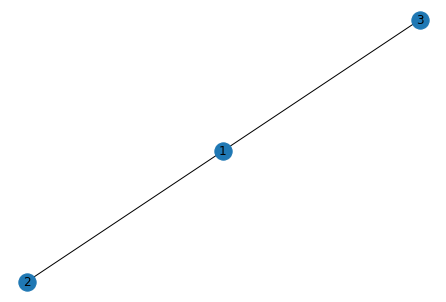

In [145]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(1,3)
nx.draw(G, with_labels=True)
plt.show()

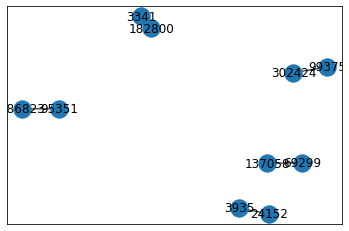

In [169]:
G_symmetric = nx.Graph()

for index, row in socialgraph.sample(5).iterrows():
    G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])

# for index, row in socialgraph.sample(100).iterrows():
#     if index < 60:
#         G_symmetric.add_edge(row['first_user_id'],row['second_user_id'])
#     else:
#         break

nx.spring_layout(G_symmetric)
nx.draw_networkx(G_symmetric)

In [172]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

#geometry = [Point(xy) for xy in zip(users['longitude'],users['latitude'])]
geo_df = gpd.GeoDataFrame(users)

AttributeError: No geometry data set yet (expected in column 'geometry'.)

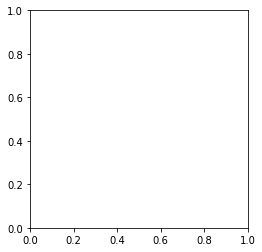

In [175]:
geo_df.plot()

In [173]:
users

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


## What are venue user like or dislike with more checkins

In [ ]:
sql = "select user_id,rating from ratings where rating=1"

# 4. Experiments

In [41]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

In [37]:
users

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [70]:
features = users.copy()
features

,id,latitude,longitude
0,1,45.072464,-93.455788
1,2,30.669682,-81.462592
2,3,43.549975,-96.700327
3,4,44.840798,-93.298280
4,5,27.949436,-82.465144
...,...,...,...
2153464,2153498,0.000000,0.000000
2153465,2153499,0.000000,0.000000
2153466,2153500,0.000000,0.000000
2153467,2153501,0.000000,0.000000


In [71]:
labels = features['id']
labels

0                1
1                2
2                3
3                4
4                5
            ...   
2153464    2153498
2153465    2153499
2153466    2153500
2153467    2153501
2153468    2153502
Name: id, Length: 2153469, dtype: int64

In [72]:
features.drop(labels=['id'],axis=1,inplace=True)

In [85]:
from sklearn.preprocessing import MinMaxScaler

In [89]:
np.array(features['latitude'])

array([45.0724642, 30.6696818, 43.5499749, ...,  0.       ,  0.       ,
        0.       ])

In [88]:
lat_scaler = MinMaxScaler()
lat_scaler.fit()

ValueError: Expected 2D array, got 1D array instead:
array=[45.0724642 30.6696818 43.5499749 ...  0.         0.         0.       ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [57]:
np.array(features)

array([[ 45.0724642, -93.4557877],
       [ 30.6696818, -81.4625919],
       [ 43.5499749, -96.700327 ],
       ...,
       [  0.       ,   0.       ],
       [  0.       ,   0.       ],
       [  0.       ,   0.       ]])

In [58]:
kmeans_model = KMeans(n_clusters=5, max_iter=10000).fit(features)

In [59]:
print('Silhouette_score: ', metrics.silhouette_score(features, kmeans_model.labels_))

KeyboardInterrupt: 

In [ ]:
kmeans_model.labels_

In [ ]:
centroids = kmeans_model.cluster_centers_
centroids

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

plt.scatter(centroids[:,0], centroids[:,1], c='r', s=250, marker='s')

for i in range(len(centroids)):
    plt.annotate(i , (centroids[i][0], centroids[i][1]), fontsize=20)

In [66]:
import math
usr = users.copy()
print(usr)
#usr['x'] = math.cos(usr['latitude'].astype('float')) * math.cos(usr['longitude'].astype('float'))
#usr['y'] = math.cos(usr['latitude'].astype('float')) * math.sin(usr['longitude'].astype('float'))
#usr['y'] = math.sin(usr['latitude'].astype('float'))
#usr

              id   latitude  longitude
0              1  45.072464 -93.455788
1              2  30.669682 -81.462592
2              3  43.549975 -96.700327
3              4  44.840798 -93.298280
4              5  27.949436 -82.465144
...          ...        ...        ...
2153464  2153498   0.000000   0.000000
2153465  2153499   0.000000   0.000000
2153466  2153500   0.000000   0.000000
2153467  2153501   0.000000   0.000000
2153468  2153502   0.000000   0.000000

[2153469 rows x 3 columns]


## How many users check-in each venues?

In [147]:
sql = "select venue_id, count(*) from checkins group by venue_id order by count(*) desc"
venue_checkins = pd.read_sql_query(sql, conn)

In [148]:
venue_checkins.shape

(83999, 2)

In [150]:
venue_checkins.head(5)

,venue_id,count(*)
0,5222,25366
1,7620,23622
2,2297,23415
3,11195,19463
4,11138,18088


In [136]:
checkins['user_id']

0           539270
1          1330941
2          1330942
3           282798
4           376793
            ...   
1021961     244608
1021962    2153502
1021963     592192
1021964     494946
1021965    1368301
Name: user_id, Length: 1021966, dtype: int64

In [140]:
checkins['user_id_cat'] = checkins['user_id'].astype("category").cat.codes

In [139]:
checkins

,id,user_id,venue_id,latitude,longitude,created_at,user_id_cat
0,16,539270,1206,41.878114,-87.629798,2011-12-08 05:08:42,90557
1,17,1330941,1206,0.000000,0.000000,2011-12-08 04:32:19,156531
2,18,1330942,1206,0.000000,0.000000,2011-12-08 04:29:38,156532
3,19,282798,1206,41.878114,-87.629798,2011-12-08 04:26:06,53969
4,20,376793,1206,41.878114,-87.629798,2011-12-08 04:17:50,69685
...,...,...,...,...,...,...,...
1021961,1021977,244608,11138,0.000000,0.000000,2012-04-23 01:47:05,48665
1021962,1021978,2153502,783,0.000000,0.000000,2012-04-23 01:42:42,485380
1021963,1021979,592192,82919,40.239812,-76.919974,2012-04-22 23:26:48,95607
1021964,1021980,494946,68691,32.912624,-96.638883,2012-04-23 00:36:33,85880


# Analysis

In [117]:
checkins['user_id']

0           539270
1          1330941
2          1330942
3           282798
4           376793
            ...   
1021961     244608
1021962    2153502
1021963     592192
1021964     494946
1021965    1368301
Name: user_id, Length: 1021966, dtype: int64

In [118]:
checkins['user_id_cat'] = checkins['user_id'].astype("category").cat.codes

In [119]:
checkins[['user_id','user_id_cat']][]

,user_id,user_id_cat
0,539270,90557
1,1330941,156531
2,1330942,156532
3,282798,53969
4,376793,69685
...,...,...
1021961,244608,48665
1021962,2153502,485380
1021963,592192,95607
1021964,494946,85880


In [103]:
from scipy.sparse import coo_matrix

ratings['user_id'] = ratings['user_id'].astype("category")
ratings['venue_id'] = ratings['venue_id'].astype("category")
ratings_matrix = coo_matrix((ratings['rating'].astype(float),
                            (ratings['user_id'].cat.codes.copy(),
                             ratings['venue_id'].cat.codes.copy())))


In [109]:
ratings['user_id']

0                1
1                1
2                1
3                1
4                1
            ...   
2809575    2153498
2809576    2153499
2809577    2153500
2809578    2153501
2809579    2153502
Name: user_id, Length: 2809580, dtype: category
Categories (661986, int64): [1, 2, 3, 4, ..., 2153499, 2153500, 2153501, 2153502]

In [88]:
ratings['user_id'].cat

In [85]:
ratings['user_id'].cat.codes

0               0
1               0
2               0
3               0
4               0
            ...  
2809575    661981
2809576    661982
2809577    661983
2809578    661984
2809579    661985
Length: 2809580, dtype: int32

In [10]:
user_factors, venue_factors = implicit.alternating_least_squares(ratings_matrix, factors=10, regularization=0.01)

This method is deprecated. Please use the AlternatingLeastSquares class instead


  0%|          | 0/15 [00:00<?, ?it/s]

In [17]:
user_factors[30]

array([ 0.13419002,  0.00781012, -0.00983691,  0.0860741 , -0.01615641,
       -0.05233343, -0.06908152,  0.00254496,  0.04640532,  0.06905014],
      dtype=float32)

In [11]:
user = venue_factors.dot(user_factors[30])

In [19]:
ratings_matrix.shape

(661986, 1140494)

In [15]:
import heapq
heapq.nlargest(3, range(len(user)), user.take)

[5179, 24, 11150]

In [ ]:
top_venues = pd.reqd_sql_query("select venue_id")

# Close database connection

In [18]:
conn.close()
print("Database closed successfully")

Database closed successfully
